In [5]:
import keras.utils
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.losses import binary_crossentropy
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

In [6]:
label_encoder = LabelEncoder()
train_file = 'twitter_training.csv'
val_file = 'twitter_validation.csv'
#load data and specify the text column and the sentiment column
#Train data
train_data = pd.read_csv(train_file)
X_train = train_data.iloc[:, 3].values  #text column
y_train = train_data.iloc[:, 2].values  #sentiment column
#Validation data
val_data = pd.read_csv(val_file)
X_val = val_data.iloc[:, 3].values  #text column
y_val = val_data.iloc[:, 2].values  #sentiment column

#encoded the label to a numerical tag for model to understand
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)


In [7]:
max_words = 5000  # Maximum number of words to consider
max_len = 100  # Maximum length of a sequence
X_train = np.array(X_train, dtype=str)
X_val = np.array(X_val, dtype=str)
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_train_seq = keras.utils.pad_sequences(X_train_seq, maxlen=max_len)
X_val_seq = keras.utils.pad_sequences(X_val_seq, maxlen=max_len)

In [8]:
embedding_dim = 100  # Dimensionality of word embeddings
num_filters = 128  # Number of filters in the convolutional layer
kernel_size = 3
num_classes = len(label_encoder.classes_)  # Number of output classes
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Conv1D(num_filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




In [9]:
batch_size = 32
epochs = 10

model.fit(X_train_seq, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_seq, y_val))


Epoch 1/10
2334/2334 [==============================] - 32s 14ms/step - loss: 0.8539 - accuracy: 0.6549 - val_loss: 0.3942 - val_accuracy: 0.8709
Epoch 2/10
2334/2334 [==============================] - 31s 13ms/step - loss: 0.4381 - accuracy: 0.8382 - val_loss: 0.2190 - val_accuracy: 0.9409
Epoch 3/10
2334/2334 [==============================] - 31s 13ms/step - loss: 0.2512 - accuracy: 0.9091 - val_loss: 0.1950 - val_accuracy: 0.9520
Epoch 4/10
2334/2334 [==============================] - 31s 13ms/step - loss: 0.1660 - accuracy: 0.9389 - val_loss: 0.1991 - val_accuracy: 0.9550
Epoch 5/10
2334/2334 [==============================] - 32s 14ms/step - loss: 0.1285 - accuracy: 0.9517 - val_loss: 0.2310 - val_accuracy: 0.9530
Epoch 6/10
2334/2334 [==============================] - 35s 15ms/step - loss: 0.1134 - accuracy: 0.9563 - val_loss: 0.2795 - val_accuracy: 0.9530
Epoch 7/10
2334/2334 [==============================] - 34s 14ms/step - loss: 0.1020 - accuracy: 0.9596 - val_loss: 0.2527 -

In [10]:
loss, accuracy = model.evaluate(X_val_seq, y_val)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

32/32 [==============================] - 0s 4ms/step - loss: 0.2968 - accuracy: 0.9570
Validation loss: 0.2968013286590576
Validation accuracy: 0.9569569826126099


32/32 [==============================] - 0s 4ms/step


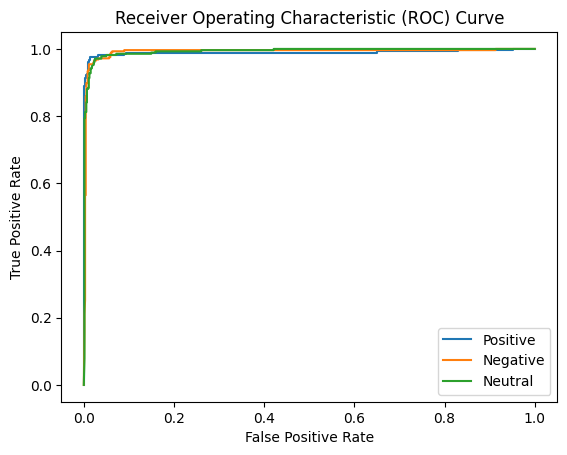

AUC (Positive): 0.989373160048826
AUC (Negative): 0.9916752665978672
AUC (Neutral): 0.9927972839185174


In [11]:
X_val_seq = keras.utils.pad_sequences(X_val_seq, maxlen=max_len)  # Pad validation sequences
y_pred_probs = model.predict(X_val_seq)

# Extract probabilities for each class
class_probs = y_pred_probs[:, 1:]  # Exclude probabilities for the first class (irrelevant)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
auc = dict()
for i in range(num_classes - 1):
    fpr[i], tpr[i], _ = roc_curve((y_val == i + 1).astype(int), class_probs[:, i])
    auc[i] = roc_auc_score((y_val == i + 1).astype(int), class_probs[:, i])

# Plot ROC curves for each class
plt.figure()
plt.plot(fpr[0], tpr[0], label='Positive')
plt.plot(fpr[1], tpr[1], label='Negative')
plt.plot(fpr[2], tpr[2], label='Neutral')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print AUC for each class
print(f"AUC (Positive): {auc[0]}")
print(f"AUC (Negative): {auc[1]}")
print(f"AUC (Neutral): {auc[2]}")

In [19]:
y_pred = model.predict(X_val_seq)
# Convert numerical labels to original labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_labels)

# Convert true labels to original labels
y_val_labels = label_encoder.inverse_transform(y_val)

# Generate classification report
report = classification_report(y_val_labels, y_pred_labels)
print(report)

32/32 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

  Irrelevant       0.96      0.94      0.95       171
    Negative       0.96      0.97      0.97       266
     Neutral       0.95      0.96      0.96       285
    Positive       0.95      0.95      0.95       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999

